# CS188 Project 2 - Binary Classification Comparative Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

<b><u>DEFINITIONS</b></u>


<b> Binary Classification:</b>
In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

<b> Supervised Learning:</b>
This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>cholserum:</b> Cholestoral in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeakST:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>Sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    


## Loading Essentials and Helper Functions 

In [1]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42) 

In [2]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Part 1. Load the Data and Analyze

Let's first load our dataset so we'll be able to work with it. (correct the relative path if your notebook is in a different directory than the csv file.)

In [4]:
ROOT_DIR = "."
file_path = os.path.join(ROOT_DIR, "heartdisease.csv")
data = pd.read_csv(file_path)

### Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method,  the describe method, and the info method to display some of the rows so we can visualize the types of data fields we'll be working with.

In [5]:
print(data.head())
print(data.describe())
print(data.info())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal   sick  
0   0     1  False  
1   0     2  False  
2   0     2  False  
3   0     2  False  
4   0     2  False  
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.0000

### Sometimes data will be stored in different formats (e.g., string, date, boolean), but many learning methods work strictly on numeric inputs. Call the info method to determine the datafield type for each column. Are there any that are problemmatic and why?

First, the label "sick" needs to be made a numeric format (most likely true=1, false=0), since all attributes, including the labels, need to be numeric. Next, cp, (possibly) restecg, slope, and thal are all categorical variables using numerical values to specify the categories. These numeric values imply an ordinal nature to each of these features, which is not necessarily true. These features will most likely have to be encoded in order to be used in our models.

### Determine if we're dealing with any null values. If so, report on which columns? 

In [6]:
incomplete_rows = data[data.isnull().any(axis=1)].head()
incomplete_rows

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick


We are not dealing with any null values.

### Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean sick variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original sick datafield from the dataframe. (hint: try label encoder or .astype()

In [7]:
le = LabelEncoder()
sick_encoded = le.fit_transform(data['sick'])
data["sick"] = sick_encoded
#ohe = OneHotEncoder()
#feat_to_tf = ['cp', 'restecg', 'slope', 'thal']
#cp_encoded = ohe.fit_transform(data[feat_to_tf]).toarray()
#new_features = ohe.get_feature_names(feat_to_tf)
#data[new_features] = cp_encoded
#data = data.drop(feat_to_tf, axis=1)

### Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to ascertain how each variable performs (is it a binary, or limited selection, or does it follow a gradient? 

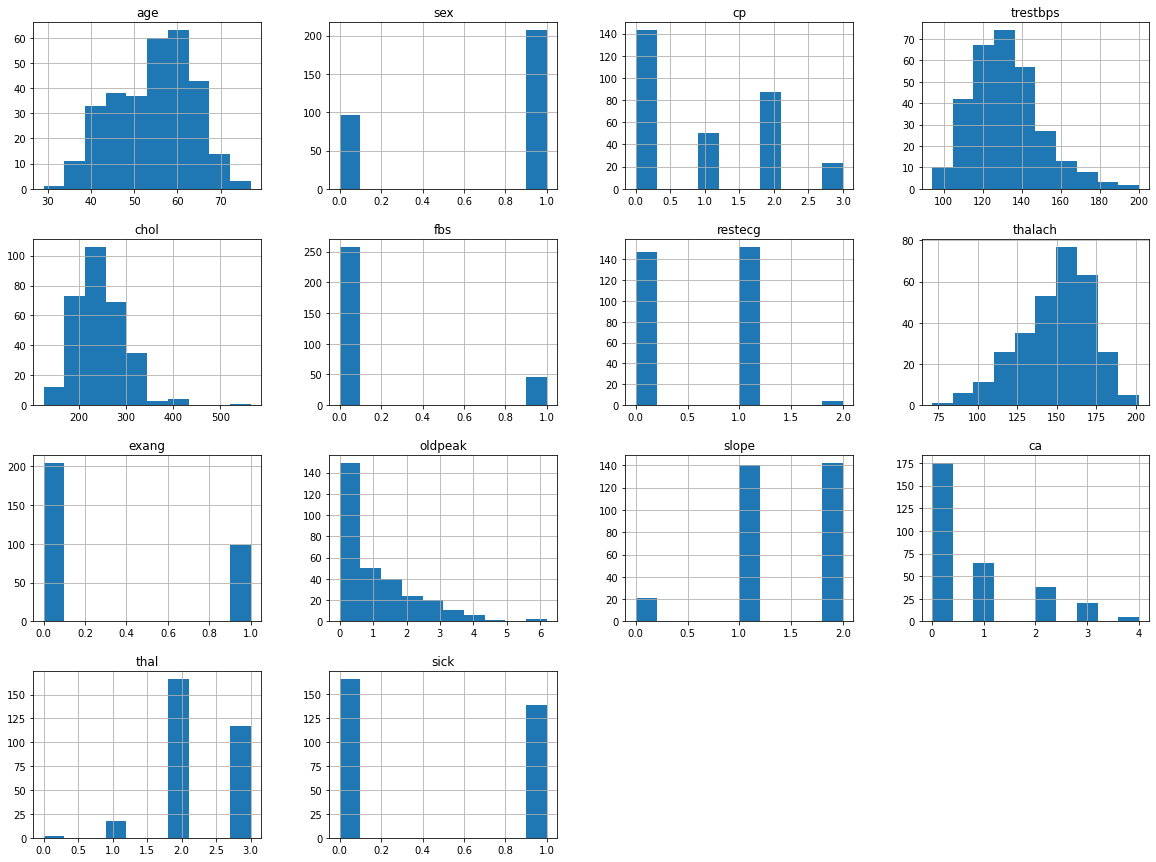

In [8]:
data.hist(figsize=(20,15), align='mid')
plt.show()

### We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results: 

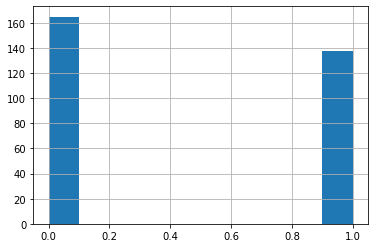

0    165
1    138
Name: sick, dtype: int64

In [9]:
data['sick'].hist(align='mid')
plt.show()
data['sick'].value_counts()

The results indicate that there are 165 healthy individuals and 138 sick individuals in this dataset. There is most likely enough sick individuals in this data to classify new individuals into either category.

### Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

A problem of artifically balancing a dataset is that we lose the information about the frequency of each label occurring, which could lead to bias and not generalizing well to test data. Generally, this could occur when you simply don't have enough data overall, and try to balance the dataset. We typically do artificial balancing so that the model can pick up some of the patterns related to the minority label(s), but doing so with a small set of data can lead to overclassification of the minority label.

### Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations. Intuitively, why do you think some variables correlate more highly than others (hint: one possible approach you can use the sns heatmap function to map the corr() method)?

<AxesSubplot:>

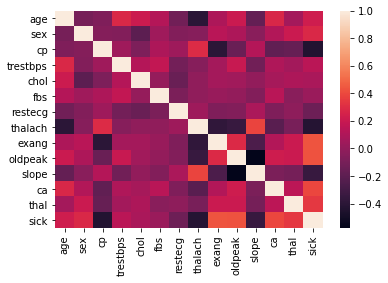

In [10]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix)

There are multiple features which have some correlation (both positive and negative) to being sick.
First, the positive correlations:
1)exang: Angina is chest discomfort, commonly caused by the arteries not supplying enough blood to the heart for it to pump to the rest of the body. This can be pronounced in individuals with heart disease, which shows in this positive correlation, indicating those who experience exercise-induced angina tend to be sick.
2)oldpeak: When depression is induced by exercise more than rest, one can interpret this as an individual who dislikes exercise and most likely does not exercise enough. Those who don't exercise often experience health problems due to a weak cardiovascular system and weight gain. This is evidenced by the positive correlation between oldpeak and sick.
3)ca: While I don't have a good idea of what the fluoroscopy coloring major vessels indicates, there is a positive correlation between the number of vessels colored and being sick.

Second, the negative correlation:
1)thalach: This is the feature for maximum heart rate achieved. A higher heart rate indicates the heart is working harder to pump blood throughout the individual's body. This is a very interesting correlation, since one would assume a higher max heart would contribute to a greater chance of heart disease, but in this case, there is a negative correlation.

I am ignoring n-ary categorical features for now since they have not yet been one-hot encoded, which is preserving some ordinality which may not be true.

## Part 2. Prepare the Data and run a KNN Model

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

Specifically, we're going to ask you to prepare 2 batches of data: 1. Will simply be the raw numeric data that hasn't gone through any additional pre-processing. The other, will be data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Save the label column as a separate array and then drop it from the dataframe. 

In [11]:
labels = data['sick']
data = data.drop(['sick'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 30.9 KB


### First Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 80% of your total dataframe (hint: use the train_test_split method) Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=24)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(242, 13)
(61, 13)
(242,)
(61,)


### In lecture we learned about K-Nearest Neighbor. One thing we noted was because KNN's rely on Euclidean distance, they are highly sensitive to the relative magnitude of different features. Let's see that in action! Implement a K-Nearest Neighbor algorithm on our data and report the results. For this initial implementation simply use the default settings. Refer to the [KNN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for details on implementation. Report on the accuracy of the resulting model.

In [13]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
print(KNN.score(X_test, y_test))

0.6721311475409836


### Now implement a pipeline of your choice. You can opt to handle categoricals however you wish, however please scale your numeric features using standard scaler

### Pipeline:

In [14]:
data_num = data.drop(["sex","cp","fbs","restecg","exang","slope","ca","thal"], axis=1)

numerical_features = list(data_num)
categorical_features = ["sex","cp","fbs","restecg","exang","slope","ca","thal"]

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])

prepared_data = full_pipeline.fit_transform(data)

### Now split your pipelined data into an 80/20 split and again run the same KNN, and report out on it's accuracy. Discuss the implications of the different results you are obtaining.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(prepared_data, labels, test_size=0.2, random_state=24)
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
print(KNN.score(X_test, y_test))

0.8524590163934426


After pipelining the data, KNN performed remarkably better than the non-pipelined version (0.6721 to 0.8525). This was due to the two actions performed in the pipelining step: scaling the numerical features, and one-hot encoding the categorical features. Since KNN is very sensitive to the magnitude of the features, scaling the numerical features prevents any features with higher magnitudes from masking the potential importance of other features with smaller magnitudes. Additionally, one-hot encoding the categorical features removes any ordinality that isn't true of those features.

### Parameter Optimization.  As we saw in HW1, the KNN Algorithm includes an n_neighbors attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now try n values of: 1, 2, 3, 5, 7, 9, 10, 20, and 50. Run your model for each value and report the accuracy for each. (HINT leverage python's ability to loop to run through the array and generate results without needing to manually code each iteration).

In [16]:
num_neighbors = [1, 2, 3, 5, 7, 9, 10, 20, 50]
for i in range(len(num_neighbors)):
    KNN = KNeighborsClassifier(n_neighbors = num_neighbors[i])
    KNN.fit(X_train, y_train)
    print(KNN.score(X_test, y_test))

0.7213114754098361
0.7213114754098361
0.8360655737704918
0.8524590163934426
0.8524590163934426
0.8360655737704918
0.8524590163934426
0.8524590163934426
0.8524590163934426


## Part 3. Additional Learning Methods 

So we have a model that seems to work well. But let's see if we can do better! To do so we'll employ multiple learning methods and compare result.

### Linear Decision Boundary Methods 

### Logistic Regression

Let's now try another classifier, we introduced in lecture, one that's well known for handling linear models: Logistic Regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

### Implement a Logistical Regression Classifier. Review the [Logistical Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for how to implement the model. Report on the same four metrics as the SVM and graph the resulting ROC curve.

0.8524590163934426
0.8846153846153846
0.7931034482758621
0.8363636363636363


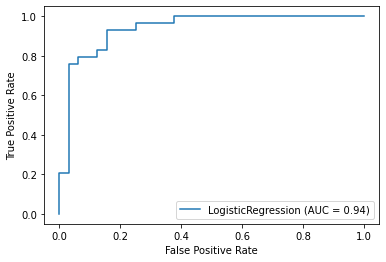

In [17]:
log_r = LogisticRegression(random_state=24)
log_r.fit(X_train, y_train)
y_pred = log_r.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test,y_pred))
print(metrics.f1_score(y_test, y_pred))
metrics.plot_roc_curve(log_r, X_test, y_test)

### Discuss what each measure is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.

The accuracy is reporting purely the percentage of correctly classified samples. The precision score is reporting the rate of true positives over the total number of samples classified as positive. The recall score is reporting the percentage of all positive samples being correctly classified as positive. The f1_score reporting an overall score using both precision and recall as factors into its output.

While accuracy may seem like the best measure to look at for measuring the performance of models, we might want to focus on reducing the number of false positive or false negatives on our test data, which are highlighted by precision_score and recall_score. As a matter of fact, f1_score is a very useful metric to look at, since it is dependent on the model's precision and recall scores. If we purely care about correctness, then accuracy would be the best measure. If we are focusing on reducing the rate of false positives, then precision would be the best measure. If we are focusing on reducing the rate of false negatives, then recall would be the best measure. Lastly, if we want a general view of the performance of our model, then f1 score would be a great measure to look at. 

### Describe what an ROC curve is and what the results of this graph seem to be indicating

An ROC curve is a visualization of the trade-off between sensitivity and specificity. It is generally used to gauge the usefulness of a model. where a curve trending the top-left corner having the best performance (high TP rate, low FP rate). This ROC curve seems to indicate that this logistic regression model is pretty good at classifying this dataset, since it has a large AUC and goes to the upper left part of the graph.

### Let's tweak a few settings. First let's set your solver to 'sag', your max_iter= 10, and set penalty = 'none' and rerun your model. Let's see how your results change!

0.8524590163934426
0.8846153846153846
0.7931034482758621
0.8363636363636363


C:\Users\yoshi\anaconda3\envs\CS188\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


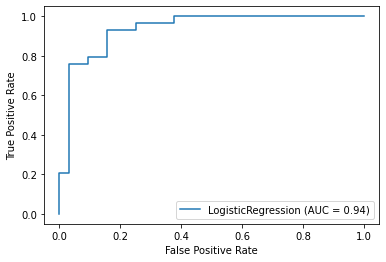

In [18]:
log_r_2 = LogisticRegression(solver='sag', max_iter=10, penalty='none', random_state=24)
log_r_2.fit(X_train, y_train)
y_pred = log_r_2.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test,y_pred))
print(metrics.f1_score(y_test, y_pred))
metrics.plot_roc_curve(log_r_2, X_test, y_test)

### Did you notice that when you ran the previous model you got the following warning: "ConvergenceWarning: The max_iter was reached which means the coef_ did not converge". Check the documentation and see if you can implement a fix for this problem, and again report your results.

0.8032786885245902
0.8148148148148148
0.7586206896551724
0.7857142857142857


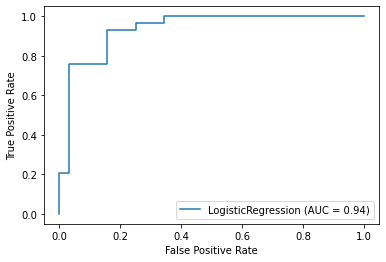

In [19]:
log_r_2 = LogisticRegression(solver='sag', max_iter=300, penalty='none', random_state=24)
log_r_2.fit(X_train, y_train)
y_pred = log_r_2.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test,y_pred))
print(metrics.f1_score(y_test, y_pred))
metrics.plot_roc_curve(log_r_2, X_test, y_test)

### Explain what you changed, and why do you think, even though you 'fixed' the problem, that you may have harmed the outcome. What other Parameters you set may have impacted this result?

I increased the number of iterations until the Convergence Warnining disappeared, but based on the metrics, the model performed worse than before. Increasing the number of iterations might lead to overfitting of the model if it takes too many iterations for the model coefficients to converge. Using no penalty may have impacted this result, since the weights for some of the features might have ballooned to values that drown out other features and in turn harms the model. Using another solver other than 'sag' might improve the model's performance as well.

### Rerun your logistic classifier, but modify the penalty = 'l1', solver='liblinear' and again report the results.

0.8688524590163934
0.8888888888888888
0.8275862068965517
0.8571428571428572


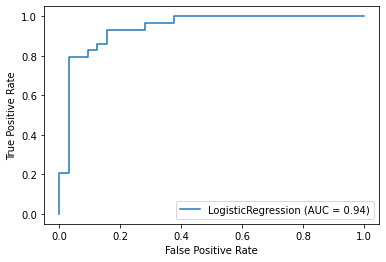

In [20]:
log_r_3 = LogisticRegression(solver='liblinear', penalty='l1', random_state=24)
log_r_3.fit(X_train, y_train)
y_pred = log_r_3.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test,y_pred))
print(metrics.f1_score(y_test, y_pred))
metrics.plot_roc_curve(log_r_3, X_test, y_test)

### Explain what what the two solver approaches are, and why the liblinear likely produced the optimal outcome. 

The first solver uses stochastic gradient descent to optimize the model. while liblinear uses the library for large linear classification, which uses a coordinate descent algorithm. Liblinear likely did better because stochastic gradient descent requires many iterations to produce a good result, since it steps one sample at a time. Additionally, based on documentation, liblinear tends to work well on datasets with high dimensionality (like this one).

### We also played around with different penalty terms (none, L1 etc.) Describe what the purpose of a penalty term is and how an L1 penalty works.

The purpose of the penalty term is to prevent the blowup in magnitude of coefficients, which can lead to a bad model. The loss function adds this penalty term, which requires the model to not only minimize the loss, but the loss + the penalty term. L1 penalty tries to get as many of the coefficients to go to zero. It tries to simplify the model by lowering the number of features that contribute to future predictions made by the model.

### SVM (Support Vector Machine)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

### Implement a Support Vector Machine classifier on your pipelined data. Review the [SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for how to implement a model. For this implementation you can simply use the default settings, but set probability = True.

In [21]:
SVM = SVC(probability=True, random_state=24)
SVM.fit(X_train, y_train)

SVC(probability=True, random_state=24)

### Report the accuracy, precision, recall, F1 Score, and confusion matrix and ROC Curve of the resulting model.

0.8524590163934426
0.8846153846153846
0.7931034482758621
0.8363636363636363


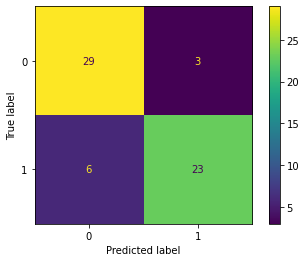

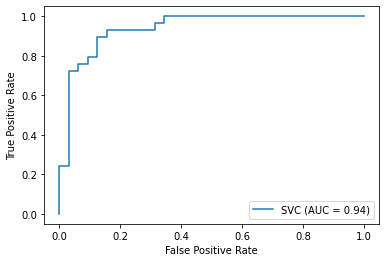

In [22]:
y_pred = SVM.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test,y_pred))
print(metrics.f1_score(y_test, y_pred))
metrics.plot_confusion_matrix(SVM, X_test, y_test)
metrics.plot_roc_curve(SVM, X_test, y_test)

### Rerun your SVM, but now modify your model parameter kernel to equal 'linear'. Again report your Accuracy, Precision, Recall, F1 scores, and Confusion matrix and plot the new ROC curve.  

0.8688524590163934
0.92
0.7931034482758621
0.851851851851852


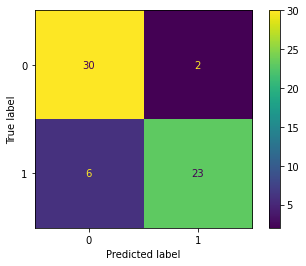

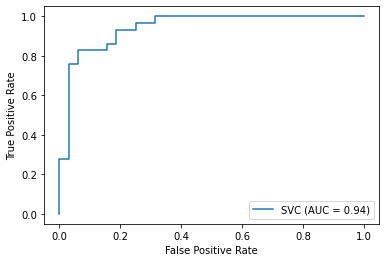

In [23]:
SVM_2 = SVC(kernel='linear', probability=True, random_state=24)
SVM_2.fit(X_train, y_train)
y_pred = SVM_2.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test,y_pred))
print(metrics.f1_score(y_test, y_pred))
metrics.plot_confusion_matrix(SVM_2, X_test, y_test)
metrics.plot_roc_curve(SVM_2, X_test, y_test)

### Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

Changing the kernel of the SVC increased all scores except for the recall score. By making the kernel linear, which resulted in better scores, this might mean that the dataset is mostly linearly separable, not requiring a mapping to a higher dimension. Mapping the data to a higher dimension might have grouped point with different labels together simply because the dimensionality was so large.

### Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary?

SVM finds the best boundary by maximizing the margin of the boundary, while logistic regression doesn't do so, instead by modifying its sigmoid curve to achieve the best classification results. 

## Baysian (Statistical) Classification

In class we learned about Naive Bayes, and statistical classification.

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Bayes’ theorem states the following relationship, given class variable Y  and dependent feature vector X1 through Xn. 

### Please implement a Naive Bayes Classifier on the pipelined data. For this model simply use the default parameters. Report out the number of mislabeled points that result, along with the accuracy, precision, recall, F1 Score and Confusion Matrix. Refer to documentation on implementing a NB Classifier [here](https://scikit-learn.org/stable/modules/naive_bayes.html)

0.8688524590163934
0.8888888888888888
0.8275862068965517
0.8571428571428572


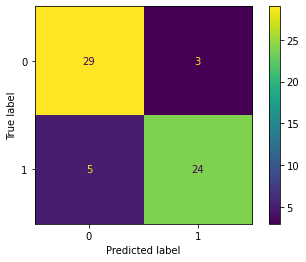

In [24]:
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test,y_pred))
print(metrics.f1_score(y_test, y_pred))
metrics.plot_confusion_matrix(NB, X_test, y_test)

### Discuss the observed results. What assumptions about our data are we making here and why might those be inacurate?

When using a Naive Bayes classifier, we assume that all of the features are independent of each other. This is often times not true at all in real-world situations, so in reality multiple features have some correlation.

## Cross Validation and Model Selection

You've sampled a number of different classification techniques, leveraging clusters, linear classifiers, and Statistical Classifiers, as well as experimented with tweak different parameters to optimize perfiormance. Based on these experiments you should have settled on a particular model that performs most optimally on the chosen dataset. 

Before our work is done though, we want to ensure that our results are not the result of the random sampling of our data we did with the Train-Test-Split. To ensure otherwise we will conduct a K-Fold Cross-Validation of our top two performing models, assess their cumulative performance across folds, and determine the best model for our particular data. 

## Select your top 2 performing models and run a K-Fold Cross Validation on both (use 10 folds). Report your best performing model.

In [25]:
KF = KFold(n_splits=10, random_state=24, shuffle=True)
log_r_3 = LogisticRegression(solver='liblinear', penalty='l1', random_state=24)
NB = GaussianNB()

log_r_3_val_score = cross_val_score(log_r_3, prepared_data, labels, cv=KF)
NB_val_score = cross_val_score(NB, prepared_data, labels, cv=KF)

print(log_r_3_val_score.mean())
print(NB_val_score.mean())

0.8512903225806452
0.7925806451612905


Overall, it seems the Logistic Regression model using the liblinear solver and l1 penalty performs the best, with a mean accuracy score of 0.8513.